# Clean data

## Step 1

1. Transpose data so routes are stored in rows 
2. Remove all columns aside from grade and holds  
3. Remove route 304387 as it includes an invalid handhold


In [20]:
import pandas as pd
#load data
data2016 = pd.read_json("raw/moonboard_problems_setup_2016.json")
#transpose data
data2016 = data2016.transpose()

print("Size of Data")
print(data2016.shape)
print(data2016.iloc[0])

#generate a copy for future reference
copy_data2016 = data2016.copy(deep=True)

#drop unecessary data
data2016 = data2016.drop(columns=['Method', 'Name', 'MoonBoardConfigurationId', 'Setter',
       'Rating', 'Repeats', 'Holdsetup', 'IsBenchmark', 'IsAssessmentProblem', 'DateInserted'])

print("-------")
print(data2016.loc[304387]["Moves"]) #hold A6 is illegally in this route
data2016.drop(304387,inplace=True)


Size of Data
(25907, 12)
Method                                                      Feet follow hands
Name                                                         OFF THE MATTRESS
Grade                                                                     8A+
MoonBoardConfigurationId                                                    0
Setter                      {'Nickname': 'bcy', 'Firstname': 'Bocheng', 'L...
Rating                                                                      0
Repeats                                                                     0
Holdsetup                   {'Id': 1, 'Description': 'MoonBoard 2016', 'Ho...
IsBenchmark                                                             False
IsAssessmentProblem                                                     False
Moves                       [{'Id': 1910055, 'Description': 'K18', 'IsStar...
DateInserted                                            /Date(1554298797933)/
Name: 341208, dtype: object
-------
[{'

## Step 2

1. Convert *Moves* Col into 3 arrays of 18x11
2. Check for duplicates
3. Show a frequency graph to get an idea of the dataset

Example Route
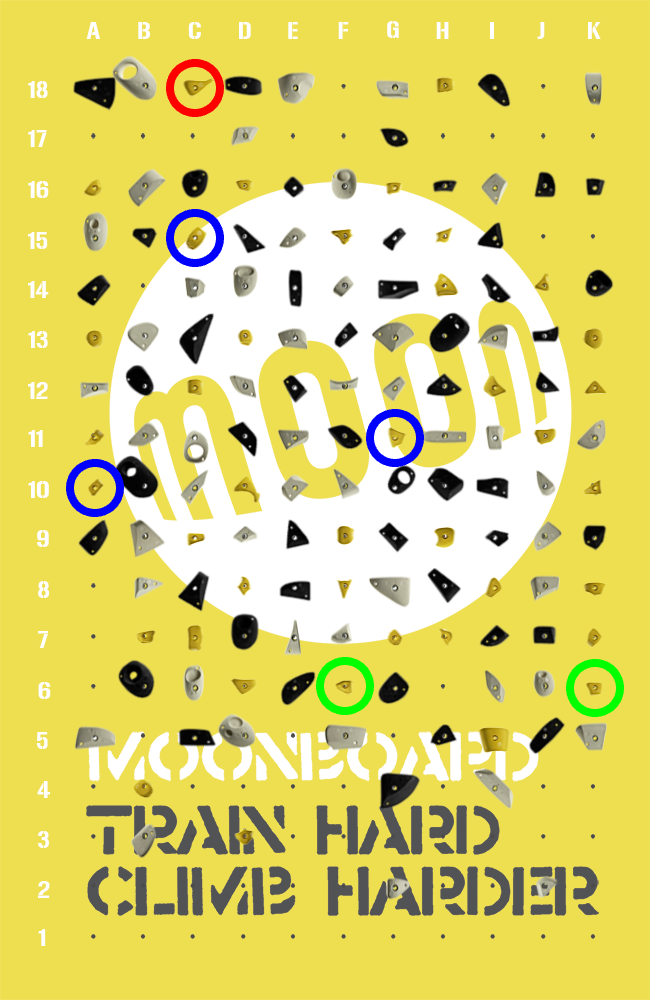

In [21]:
import numpy as np

def convert_key(key):
    '''
    Converts desciption (e.g B10) into a row and column index
    for a 18x11 array
    '''
    letter = key[0]
    number = key[1:]
    
    col = ord(letter) - 65
    row = 18-int(number)

    return row,col

def convert_moves(moves):
    '''
    Converts the list of dictionarys from the moves column into
    3 18x11 arrays for start/middle/end holds
    '''
    holds = np.zeros((3,18,11),dtype=bool)

    
    for dic in moves:
        key = dic['Description']
        
        row,col = convert_key(key)
        if dic['IsStart']:
            holds[0,row,col] = True
        elif dic['IsEnd']:
            holds[2,row,col] = True
        else:
            holds[1,row,col] = True
            
    return holds


data2016["Moves"] = data2016["Moves"].apply(convert_moves)

In [3]:
#we end up with the list duplicates of pairwise duplicates
#this process can take 20+ minutes so we have saves the duplicates as a .npy file

all_moves = []

def dup(all_moves,move):
    for m in all_moves:
        if (m[0] == move).all():
            return True,m[1]
        
    return False,_

duplicates = []

for i,line in data2016.iterrows():
    isdup,k = dup(all_moves,line["Moves"])
    if isdup:
        print(i,k,line["Grade"],copy_data2016.loc[k]["Grade"],copy_data2016.loc[i]["Name"],copy_data2016.loc[k]["Name"])
        duplicates.append((i,k))
    else:
        all_moves.append((line["Moves"],i))
        
print('Finished finding duplicates')

339300 339301 7A+ 7A+ JACK REACHER JACK REACHER
338209 338210 6B+ 6B+ MEG1 MEG1
330643 330644 6B+ 6B+ SON OF KRYPTON SON OF KRYPTON
326007 326008 7B 7B RECEPÇÃO RECEPÇÃO
325820 325821 7A+ 7A+ BEST KEPT SECRET BEST KEPT SECRET
323993 323994 6B+ 6B+ ELY ELY
323805 323806 6B+ 6B+ NOT MINE NOT MINE
323804 323806 6B+ 6B+ NOT MINE NOT MINE
321997 321998 6B+ 6B+ DIONYSUS DIONYSUS
314432 314433 6C 6C BZ - WALKING ON THE MOON BZ - WALKING ON THE MOON
313869 313870 7A 7A THE LAST BIG BANG THE LAST BIG BANG
313610 313611 7B 7B YUMMI! YUMMI!
312479 312480 7C 7C DANG MAGIC DANG MAGIC
310477 310478 7B 7B SNIKERS SNIKERS
308838 308839 6C 7A RACHEL RACHEL’S PROBLEM
306036 306037 6B+ 6B+ ЛЕГХКАЯ ПРОБЛЕМА ЛЕГХКАЯ ПРОБЛЕМА
305590 305591 6B+ 6B+ ВСЁ СНАЧАЛА№2 ВСЁ СНАЧАЛА№2
295942 295946 7C 7C JARLZ YARLAMAGNE
286817 286818 7A 7A DON’T TRY THAT CLIMB DON’T TRY THAT CLIMB
285167 287287 7A 7A SUPER! ST. ELMO'S FIRE
281999 282001 6B+ 6B+ SOMETHING TO WARM UP SOMETHING TO WARM UP
278472 278474 6B+ 6B+ FRANK TH

In [9]:
np.save('2016Duplicates.npy',duplicates)

In [5]:
duplicates = np.load('2016Duplicates.npy')
issues = []

for i,j in duplicates:
    if data2016.loc[i]["Grade"] == data2016.loc[j]["Grade"]:
        data2016.drop(i,inplace=True)
    else:
        issues.append((i,j))
        

for pair in issues:
    print(pair)

(308838, 308839)
(254067, 269201)
(235880, 263369)
(233871, 237343)
(190389, 276317)
(184714, 253376)
(184295, 283540)
(135425, 146578)
(83277, 124727)
(67138, 70051)
(44828, 114054)
(44584, 252606)
(24826, 174872)
(21810, 78276)
(20038, 52770)
(19224, 271465)


In [22]:
# we can see from the printed pairs above all of them are independent
# so we can drop either i or j depending on which one was repeated less
for i,j in issues:
    if copy_data2016.loc[i]["Repeats"] < copy_data2016.loc[j]["Repeats"]:
        data2016.drop(i,inplace=True)
    else:
        data2016.drop(j,inplace=True)
        
data2016.shape

(25890, 2)

Text(0.5, 1.0, 'End Holds')

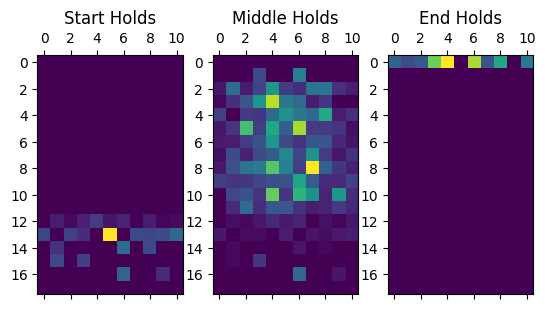

In [23]:
import matplotlib.pyplot as plt




freq = sum(data2016["Moves"])

figure, axis = plt.subplots(1,3)

axis[0].matshow(freq[0])
axis[0].set_title('Start Holds')
axis[1].matshow(freq[1])
axis[1].set_title('Middle Holds')
axis[2].matshow(freq[2])
axis[2].set_title('End Holds')



## Step 3
(note: the dataset has now been reduced from 25907 to 25841 routes)

1. Create a new dataframe that is ready to be used a training data

2. We know that some holds are never used on the moonboard such as A1 so we will reduce the size of the *moves* arrary by 
 - Remove row 7-18 from start holds
 - Remove all bar row 18 from end holds 
 - Remove *empty holds* from whole dataset
 
3. Flatten 3xMxN hold data into a vector

In [105]:
import pandas as pd
training_data = data2016.copy()

training_freq = sum(training_data["Moves"])
print('--------')
for i,row in enumerate(training_freq[0]):
    print('Routes with start holds in row index =',i,np.sum(row))
print('--------')
for i,row in enumerate(training_freq[1]):
    print('Routes with middle holds in row index =',i,np.sum(row))
print('--------')
for i,row in enumerate(training_freq[2]):
    print('Routes with end holds in row index =',i,np.sum(row))

--------
Routes with start holds in row index = 0 0
Routes with start holds in row index = 1 0
Routes with start holds in row index = 2 0
Routes with start holds in row index = 3 0
Routes with start holds in row index = 4 0
Routes with start holds in row index = 5 0
Routes with start holds in row index = 6 0
Routes with start holds in row index = 7 0
Routes with start holds in row index = 8 0
Routes with start holds in row index = 9 0
Routes with start holds in row index = 10 0
Routes with start holds in row index = 11 0
Routes with start holds in row index = 12 5358
Routes with start holds in row index = 13 20719
Routes with start holds in row index = 14 5889
Routes with start holds in row index = 15 3305
Routes with start holds in row index = 16 3587
Routes with start holds in row index = 17 0
--------
Routes with middle holds in row index = 0 0
Routes with middle holds in row index = 1 2853
Routes with middle holds in row index = 2 10957
Routes with middle holds in row index = 3 123

### Note

We are now faced with the question of do we remove the low frequency rows in the end holds group? There are 11 holds total meaning we would lose a max of 11 routes by removing these holds. My inital thought is that we should remove as the benefit in reduction in the number of input parameters greatly outweighs the benefit from having these routes in the dataset

In [106]:
#here we must remove the routes with these handholds
to_remove = []

for i, line in training_data.iterrows():
    if np.sum(line["Moves"][2][1:,:])>0:
        training_data.drop(i,inplace=True)


In [115]:
# we are taking the 3 matricies down to just one matrix
import matplotlib.pyplot as plt
def condense(moves):
    '''
    function to remove empty rows of the dataset
    '''
    new_moves = np.zeros((22,11))
    
    new_moves[0:5,:] = moves[0][12:17,:]
    new_moves[5:21,:] = moves[1][1:17,:]
    new_moves[-1,:] = moves[2][0,:]
    
    return new_moves
    
con_freq = condense(freq)

print('Old size = ',freq.size)
print('New size = ',con_freq.size)

#plt.matshow(con_freq)


Old size =  594
New size =  242


In [109]:
#final stage of condensing 
empty_holds = ["F18",
              "J18",
              "A17","B17","C17","E17","F17","H17","I17","J17","K17",
              "J15","K15",
              "B14",
              "A8",
              "A7",
              "A6","H6",
              "B5","E5","G5",
              "A4","C4","D4","E4","F4","H4","J4","K4",
              "A3","C3","E3","F3","G3","H3","I3","J3","K3",
              "A2","B2","C2","D2","E2","F2","H2","I2","K2",
              "A1","B1","C1","D1","E1","F1","G1","H1","I1","J1","K1",]

null_moves = np.zeros((3,18,11)) #creates empty route to highlight null holds

for hold in empty_holds:
    row,col = convert_key(hold)
    
    null_moves[0][row,col] = 1
    null_moves[1][row,col] = 1
    null_moves[2][row,col] = 1
    
null_moves = condense(null_moves)

final_remove = np.where(null_moves.flatten() == 1)[0]
def final_condense(moves):
    moves = condense(moves)
    
    flat_moves = moves.flatten()
    
    k = 0
    for indx in final_remove:
        flat_moves = np.delete(flat_moves,indx-k)
        k += 1
        
    return flat_moves

   
    
training_data["Moves"] = training_data["Moves"].apply(final_condense)    
    


In [121]:
print('Total Holds Lost =',np.sum(sum(data2016["Moves"])) - np.sum(sum(training_data["Moves"])))
print('Total Routes Lost =',len(data2016) - len(training_data))
print('Final size of input vector X =',len(training_data.iloc[0]["Moves"]),'Note: starting from 594')
print('Final size of training data =',len(training_data))

Total Holds Lost = 78.0
Total Routes Lost = 11
Final size of input vector X = 164 Note: starting from 594
Final size of training data = 25879


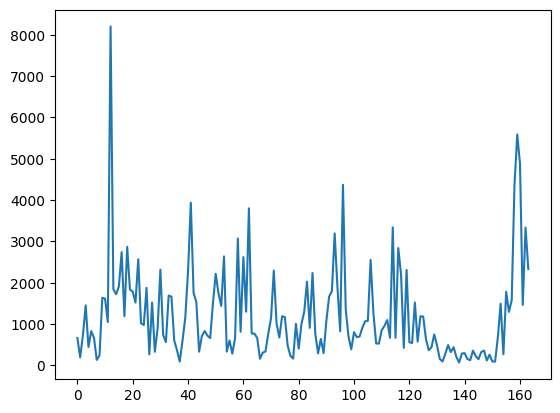

In [117]:
training_freq = sum(training_data["Moves"])

plt.plot(training_freq)

# --------------OLD PROCESSES-----------------

# of null holds =  78
# of empty array entries =  78


Text(0.5, 1.0, 'Zero - Null Holds')

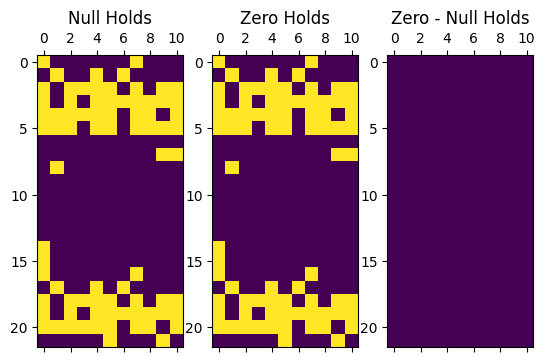

In [83]:
#testing empty holds from start diagram match holds of 0 frequency in data
empty_holds = ["F18",
              "J18",
              "A17","B17","C17","E17","F17","H17","I17","J17","K17",
              "J15","K15",
              "B14",
              "A8",
              "A7",
              "A6","H6",
              "B5","E5","G5",
              "A4","C4","D4","E4","F4","H4","J4","K4",
              "A3","C3","E3","F3","G3","H3","I3","J3","K3",
              "A2","B2","C2","D2","E2","F2","H2","I2","K2",
              "A1","B1","C1","D1","E1","F1","G1","H1","I1","J1","K1",]




null_moves = np.zeros((3,18,11))

for hold in empty_holds:
    row,col = convert_key(hold)
    
    null_moves[0][row,col] = 1
    null_moves[1][row,col] = 1
    null_moves[2][row,col] = 1
    
null_moves = condense(null_moves)

print('# of null holds = ',np.sum(null_moves==1))
print('# of empty array entries = ',np.sum(con_freq == 0))

figure, axis = plt.subplots(1,3)

axis[0].matshow(null_moves)
axis[0].set_title('Null Holds')
axis[1].matshow(con_freq == 0)
axis[1].set_title('Zero Holds')
axis[2].matshow((con_freq == 0)-null_moves)
axis[2].set_title('Zero - Null Holds')



In [86]:
#testing no data is lost during remove of null holds
final_remove = np.where(null_moves.flatten() == 1)[0]
print('# of indexes to remove =',len(final_remove))

flat_freq = condense(freq).flatten()
print('Start sum of holds =',np.sum(flat_freq))
k = 0
for indx in final_remove:
    flat_freq = np.delete(flat_freq,indx-k)
    k += 1
    
print('End sum of holds =',np.sum(flat_freq))

# of indexes to remove = 78
Start sum of holds = 198217.0
End sum of holds = 198217.0


In [9]:
pd.show_versions()

C:\Users\wwden\AppData\Local\Programs\Python\Python310\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



INSTALLED VERSIONS
------------------
commit           : 2e218d10984e9919f0296931d92ea851c6a6faf5
python           : 3.10.10.final.0
python-bits      : 64
OS               : Windows
OS-release       : 10
Version          : 10.0.19045
machine          : AMD64
processor        : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : English_United Kingdom.1252

pandas           : 1.5.3
numpy            : 1.24.2
pytz             : 2022.7.1
dateutil         : 2.8.2
setuptools       : 65.5.0
pip              : 22.3.1
Cython           : None
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 3.1.2
IPython          : 8.11.0
pandas_datareader: None
bs4              : 4.11.2
bottleneck       : None
br